In [274]:
import numpy as np 
import random
import pandas as pd
import matplotlib.pyplot as plt

## 3.1 Armado de la red y cálculo de la energía del sistema
Consideren una red cuadrada de $N\times  N$, con $N^2$ el número de átomos que componen al sistema. 

In [429]:
def Malla(N): #tamaño de cada lado de la red
    Red = []
    #Definimos lista de ceros
    for i in range(N**2):
        c = random.choice([-1,1])
        Red.extend([c])
    return Red

In [430]:
Red = Malla(3)

In [431]:
Red

[1, 1, -1, 1, 1, 1, -1, 1, 1]

In [244]:
len(Red)

9

Generen una lista con los primeros vecinos de cada sitio implementando condiciones periódicas a la frontera (lo cual es equivalente a transformar al plano en un toro). De esta forma, todos los sitios de la red tienen 4 vecinos.

In [322]:
def vecinos(N): #Vecinos
    v = np.zeros((N**2, 4), dtype=int)
    #Neighbor.site: W/ D (up, right,  down, left)
    for j in range(0,N**2):
    #up
        if (j + N) <= N**2-1:
            v[j][0] = j+N+1
        else:
            v[j][0] = j-N*(N-1)+1
    #right
        if (j+1) % N != 0:
            v[j][1] = j+2
        else:
            v[j][1] = j-N+2
    #down
        if  (j - N+1) >= 1:
            v[j][2] = j-N+1
        else:
            v[j][2] = j + N*(N-1)+1
    #left    
        if j%N != 0:
            v[j][3] = j
        else:
            v[j][3] = j+N
            
    return v

In [425]:
vecinos(3)

array([[4, 2, 7, 3],
       [5, 3, 8, 1],
       [6, 1, 9, 2],
       [7, 5, 1, 6],
       [8, 6, 2, 4],
       [9, 4, 3, 5],
       [1, 8, 4, 9],
       [2, 9, 5, 7],
       [3, 7, 6, 8]])

In [426]:
vec = vecinos(3)

Ya que hayan hecho esto, calculen la energía de un par de conguraciones de espines y un valor de J.

La energía del sistema si hacemos la aproximación a los primero 4 vecinos es:

$$E=\sum _{<i,j>}-Js_{i}s_{j}$$

In [389]:
Red = -np.ones((3**2,), dtype=int)
len(Red)

9

In [442]:
def Energia(Malla,vecinos,J):
    E0 = 0
    NxN = len(Malla)
    for j in range(0,NxN):
        for i in range(4): #Multiplicamos spin de la malla por sus vecinos
            E0 += Malla[j]*Malla[int(vecinos[j][i]-1)]
    return -J*E0

In [443]:
Energia(Red,vec,0.5)


-2.0

In [435]:
def Energia_total(Malla,vecinos,J):
    E_total = 0
    NxN = len(Malla)
    for j in range(0,NxN):
        for i in range(4): #Multiplicamos spin de la malla por sus vecinos
            E_total += -J*Malla[j]*Malla[int(vecinos[j][i]-1)]
    return E_total

In [436]:
Energia_total(Red,vec,0.5)

-2.0

### Magnetización

In [286]:
def magnetizacion(Malla):
    return sum(Malla)

In [287]:
magnetizacion(Red)

-9

## 3.2 Cálculo de la temperatura crítica del sistema

La cantidad que juega un papel fundamental en todo el análisis que hacemos es la temperatura crítica, $T_c$, que para el problema de Onsager se obtiene de resolver la siguiente ecuación trascendental:
$$2\tanh^2\left(\frac{2J}{K_B T_c}\right)=1$$
Donde $k_\beta=1.380649\times 10^{-23}J/K$

Para esto utilizamos el algoritmo de newton:


<ipython-input-468-d159f387be92>:5: RuntimeWarning: divide by zero encountered in true_divide
  f = 2*((np.tanh((2*J)/(k_β*T_c)))**2)-1


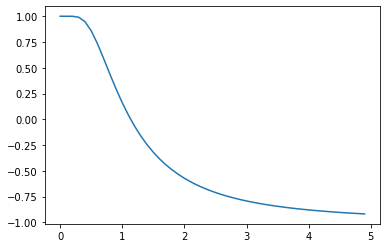

In [468]:
k_β = 1
J = 0.5
x = np.linspace(0,20,100)
#f = x**3 + 4*(x**2) - 10
f = 2*((np.tanh((2*J)/(k_β*T_c)))**2)-1
plt.plot(T_c,f) #To plot
plt.show()

In [289]:
from scipy.optimize import fsolve
k_β = 1
J = 0.5
f = lambda T_c: 2*(np.tanh((2*J)/(k_β*T_c)))**2-1

sol= fsolve(f, [0.1, 10])
sol
print("La temperatura crítica es: T_c=1.13459266")

La temperatura crítica es: T_c=1.13459266


## 3.3. Evolución y termalización del sistema

En física estadística, el objeto de mayor interés y a partir del cual se obtienen la ecuación de estado y todas las cantidades observables es la función de partición Z, que en el ensamble canónico tiene la siguiente forma:
$$Z =\sum_C e^{\beta E(C)},$$
donde la suma corre sobre todas las posibles conguraciones C que pueden tener los átomos en la red y $\beta=K_B T$ es la beta térmica. Para ejemplicar lo absurdo que sería calcular la función de partición por fuerza bruta, dado un valor para $\beta > 0$, calculen la función de partición para redes de lado $N =[2, 3, 4, 5]$ y tomen el tiempo que se lleva en hacer el cálculo. ¿Qué tanto difieren los tiempos a medida que aumenta el tamaño de la red?

In [484]:
def Termalizacion(kt,espines, nb, J, h):
    N = int(np.sqrt(len(espines))) #Magnitud de un lado de la re
    espines_inicial = copy(espines)
    enfinc = [] #Arreglo en el que pondré la energía
    magnefinc = [] #Arreglo en el que pondré la magnetización
    flip =[]
    flips_contador = 0
    lista = vecinos(N) #Vecinos de cada partícula
    for k in range(0,nb): #número de barridos
        energias = []
        magne = []
        for j in range(0,N**2-1):
            for i in range(4):
                dE = 2*J*espines[j]*Red[int(lista[j][i]-1)+h] #Evolucion del sistema de acuerdo al algoritmo de metropolis montecarlo
                pob = np.exp(-dE/kt)
                if (dE<0) & (pob>np.random.rand()):
                    espines[j] = -espines[j] #Se cambia el espín
                    flips_contador +=1
            en = Energia(espines,lista,J)
            m = sum(espines)
            energias.append([en])
            magne.append([m])
        enfinc.append([energias])
        magnefinc.append([np.abs(magne)])
    return enfinc, magnefinc, flip

In [466]:
N = 3
lista = vecinos(N)
j=0
i=1
Red[int(lista[j][i])-1]

-1

In [458]:
Red


[-1, -1, -1, 1, 1, 1, 1, 1, 1]

In [459]:
lista

array([[4, 2, 7, 3],
       [5, 3, 8, 1],
       [6, 1, 9, 2],
       [7, 5, 1, 6],
       [8, 6, 2, 4],
       [9, 4, 3, 5],
       [1, 8, 4, 9],
       [2, 9, 5, 7],
       [3, 7, 6, 8]])

In [454]:
N = 3
lista = vecinos(N)
E =[]
for j in range(0,N**2-1):
    for i in range(4):
        dE = 2*J*Red[j]*Red[int(lista[j][i]-1)]
        E += dE
print(Red)
print(E)

TypeError: 'float' object is not iterable

In [455]:
lista = vecinos(3)
lista[N**2-1]

array([3, 7, 6, 8])

In [444]:
Energia(Red, lista,0.5)

-2.0

In [488]:
energy, magnetizacion, flips = Termalizacion(2,Red, 10, 0.5, 0)
flips

[]

In [258]:
#Red = Malla(3)
#vec = vecinos(3)
#NxN = len(Red)

E0 = 0
for j in range(0,NxN):
    for i in range(0,4): #Multiplicamos spin de la malla por sus vecinos
        E0 -= Red[j]*Red[int(vec[j][i]-1)]
        
E_j=0
        
for j in range(0, NxN):
    Malla_prueba = np.copy(Red)
    Malla_prueba[j] = -Red[j]
    for i in range(0,4): #Multiplicamos spin de la malla por sus vecinos
        E_j -= Malla_prueba[j]*Malla_prueba[int(vec[j][i]-1)]

NameError: name 'numpy' is not defined

Una manera de sortear este problema es usando el algoritmo de Metrópolis con Montecarlo, que se centra en el cálculo de probabilidades de transición entre dos diferentes conguraciones (eliminando así la necesidad de la función de partición) y que tiene por objetivo generar una colección de conguraciones de espines que obedezcan la distribución del ensamble canónico. El problema con esto es que para varias iteraciones, el algoritmo produce conguraciones altamente correlacionadas entre sí y que por tanto no obedecen la distribución.

$$\frac{p(e_j)}{P(e_{j+1})}=\frac{\frac{e^{-\beta \vec{E}(e_i)}}{Z}}{\frac{e^{-\beta \vec{E}(e_i)}}{Z}}
=e^{-\beta(E(e_i)-E(e_{j+1}))}$$



 Una vez que echen a andar al algoritmo de Metrópolis para que una conguración inicial C0 evolucione a la conguración que minimiza la energía del sistema, deben termalizar el sistema, que consiste en aproximar cuál es el número adecuado de congu-
raciones intermedias que deben descartar para juntar un conjunto de Q conguraciones $\{C_1, C_2, ... , C_Q\}$ tal que todas sean estadísticamente independientes entre sí y que son las que usaran para calcular las cantidades observables del sistema. Los detalles de cómo se hace esto están en el libro y los platicaremos con detalle.

In [272]:
N=3
C_fria = -np.ones((N**2,), dtype=int)
C_fria

C_caliente = np.random.randint(size=(N, N), dtype=int)
C_caliente

TypeError: randint() takes at least 1 positional argument (0 given)

**1. ¿Cuál es la distribución del ensamble canónico?, ¿para qué tipo de sistemas sirve?**



- https://ps.uci.edu/~cyu/p115A/LectureNotes/Lecture9/html_version/
- https://estadistica-dma.ulpgc.es/FCC/05-3-Raices-de-Ecuaciones-2.html#metodo-de-la-secantehttps://estadistica-dma.ulpgc.es/FCC/05-3-Raices-de-Ecuaciones-2.html#metodo-de-la-secante
- https://tereom.github.io/fundamentos/m%C3%A9todos-de-cadenas-de-markov-monte-carlo.html#m%C3%A9todo-de-metr%C3%B3polis